# Data Quality Assessment Using a Tree Based Model

In this notebook, we illustrate basic data quality assessment of the classification of images in the MNIST dataset by a random forest model. To begin, we use scikitlearn to train a model with the MNIST dataset.

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

First we need to download the MNIST dataset.

In [2]:
mnist = fetch_openml('mnist_784', version=1, parser='pandas')

Now we can get some information about the data we loaded.  Since we used 'fetch_openml', 'mnist' is a bunch object, a container that holds both the data and some metadata.  Lets explore some details of this object.

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Now we see all of the keys that refer to the components of the bunch. Lets take a look at 'data'.

In [4]:
mnist.data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


MNIST is a collection of handwritten digits, 0-9, each represented as a 1D 784 element array.  This array is made by flattening the original 28x28 pixel grayscale image. At a glace, this may appear like the dataset is all zeros, but that is not the case.  The head of the data frame is actually just showing us a small slice of the top left and bottom right of the image.  Since the digits are relatively centered, it makes sense that all we are seeing here is zeros because that is the representation of white, the background color.  Lets reshape the first row to reconstruct the image.  

In [5]:
image = mnist.data.iloc[0].values.reshape(28, 28)

For clarity, we change the numpy print options to allow each row to be printed on its own line.

In [6]:
import numpy as np

np.set_printoptions(linewidth=np.inf)

<Token var=<ContextVar name='format_options' default={'edgeitems': 3, 'threshold': 1000, 'floatmode': 'maxprec', 'precision': 8, 'suppress': False, 'linewidth': 75, 'nanstr': 'nan', 'infstr': 'inf', 'sign': '-', 'formatter': None, 'legacy': 9223372036854775807, 'override_repr': None} at 0x0000029ECF8B0F40> at 0x0000029E9210BEC0>

In [7]:
image

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170, 253, 253, 253, 253, 253, 225, 172

Consider that 0 is pure white, 255 is pure black and 1-254 are varying shades of gray, with lower numbers being lighter shades (closer to white) and higher numbers being darker shades (closer to black). It is a little more clear that this could represent a handwritten digit.  Now lets use matplotlib to see an actual image representation. 

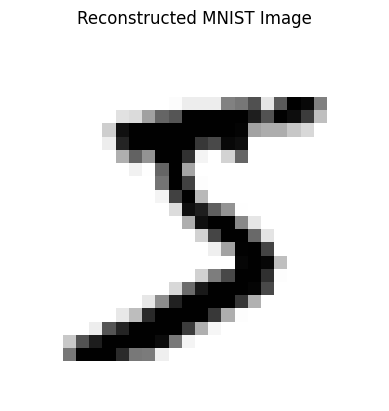

In [8]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray_r', interpolation='nearest')
plt.title('Reconstructed MNIST Image')
plt.axis('off')  # Hide the axis
plt.show()

This looks like it could be a handwritten 5. Lets check the first row of mnist.target, which contains the labels for the data.

In [9]:
mnist.target.iloc[0]

'5'

We were correct in our guess that the first row represents a 5.  The next key in the bunch is 'frame', which has 'data' and 'target' combined to a single dataframe. The rest of the keys are not important for this project.  Now that we know the important details of the dataset, lets proceed with training our model. First we assign the features to the varible 'X'.

In [10]:
X = mnist.data

Now we want to assign the target to y, but there is a small complication.

In [11]:
y = mnist.target
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 70000 entries, 0 to 69999
Series name: class
Non-Null Count  Dtype   
--------------  -----   
70000 non-null  category
dtypes: category(1)
memory usage: 68.9 KB


When we load the MNIST dataset using fetch_openml with the parser='pandas' option, the target labels (y) are often loaded as a pandas Series with a categorical data type. This is common because the labels represent discrete classes (digits 0-9), which are naturally categorical. Before training the model we should convert them to int.

In [12]:
y = y.astype(int)

Next we train the model, using 20% of the data for testing, random_state=42 for reproducibility, and a random forest consisting of 100 trees. 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Proceed by evaluating the model.

In [15]:
y_pred = rf_classifier.predict(X_test)

In [16]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9672857142857143
Confusion Matrix:
[[1325    0    4    0    1    1    3    1    6    2]
 [   0 1573    6    8    2    0    0    6    3    2]
 [   4    5 1334    4    5    1    9    8    8    2]
 [   1    0   23 1366    0    9    0   14   12    8]
 [   4    1    3    0 1257    0    2    3    3   22]
 [   1    3    3   17    4 1226    8    1    8    2]
 [   4    1    0    0    6   10 1372    0    3    0]
 [   3    5   15    0    7    1    0 1455    2   15]
 [   1    6    9   15    6   11    5    7 1290    7]
 [   4    6    5   16   20    5    1   10    9 1344]]


Looks like the model is doing a decent a job, but there are some misclassifications.  By calculating the off-diagonal row sums and off-diagonal columns sums, we can gain some more insight.

In [17]:
off_diagonal_row_sums = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)
off_diagonal_column_sums = np.sum(conf_matrix, axis=0) - np.diag(conf_matrix)

print("Off-Diagonal Row Sums:", off_diagonal_row_sums)
print("Off-Diagonal Column Sums:", off_diagonal_column_sums)

Off-Diagonal Row Sums: [18 27 46 67 38 47 24 48 67 76]
Off-Diagonal Column Sums: [22 27 68 60 51 38 28 50 54 60]


This tells us the model is most frequently misclassifying 9's and is most frequently confusing 2's with other classes.  This can be improved by better model training or improving the data quality.  For this project, we will focus on the data.  Lets determine which images the model is most uncertian about. First we need to get the probability of assigning each sample to a given class.

In [18]:
proba_train = rf_classifier.predict_proba(X_train)
proba_train

array([[0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.01, 0.02, 0.02],
       [0.  , 0.04, 0.  , ..., 0.  , 0.82, 0.02],
       ...,
       [0.  , 0.97, 0.  , ..., 0.03, 0.  , 0.  ],
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.83, 0.  , 0.05, ..., 0.  , 0.01, 0.01]])

In [19]:
proba_train.shape

(56000, 10)

The output from 'predict_proba' is an array with the elements of each row representing the probability the model assigns the sample the corresponding class.  For deeper understanding, lets look at the first row in more detail.

Predicted probabilities for sample 0:
 [0.   0.   0.   0.03 0.   0.96 0.   0.01 0.   0.  ]


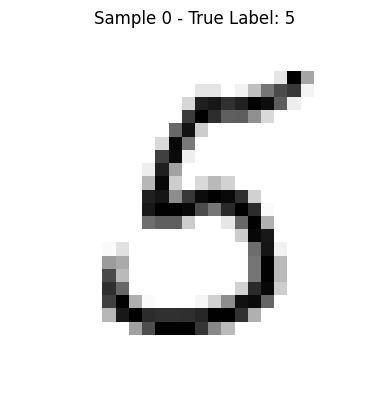

In [20]:
sample_index = 0
print(f"Predicted probabilities for sample {sample_index}:\n", proba_train[sample_index])

plt.imshow(X_train.iloc[sample_index].values.reshape(28, 28), cmap='gray_r')
plt.title(f"Sample {sample_index} - True Label: {y_train.iloc[sample_index]}")
plt.axis('off')
plt.show()

Sample 0 is pretty clearly a '5' to the human eye, and inspecting the array shows that 96% of the time the model agrees. It is labeled as a '3' or '7', 3% and 1% of times respectively.  This sample is most likely of good quality, any improvements on classification would have to come from model training. There are different methods we can use to find the most likely misclassified samples. We will use uncertianty and entropy, exploring uncertainty first. We calculate the difference between the highest and second-highest predicted probabilities for each sample, giving us a measure of how uncertain the model is for each.

In [21]:
uncertainty = np.partition(proba_train, -2, axis=1)[:, -1] - np.partition(proba_train, -2, axis=1)[:, -2]
print(uncertainty, uncertainty.shape)

[0.93 0.91 0.76 ... 0.94 1.   0.78] (56000,)


Now we have a uncertainty for each sample.  Lets take a look at the ten samples with highest uncertainty.  

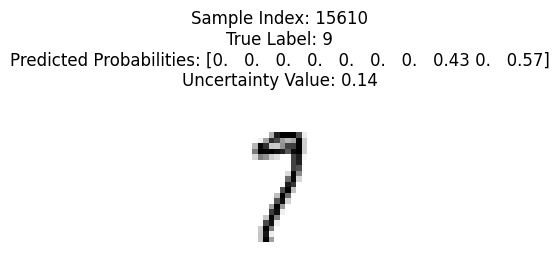

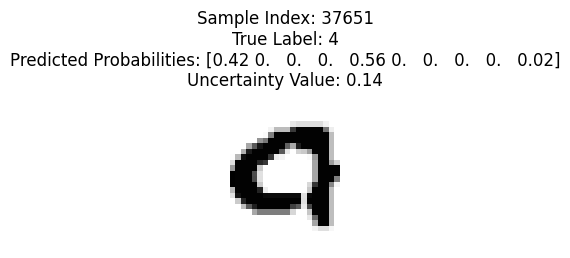

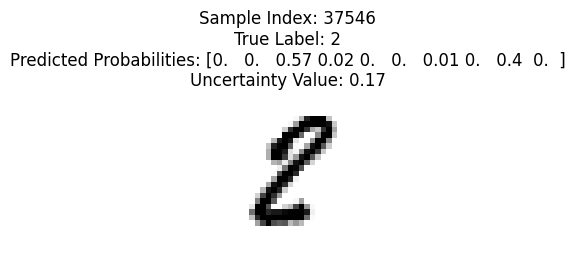

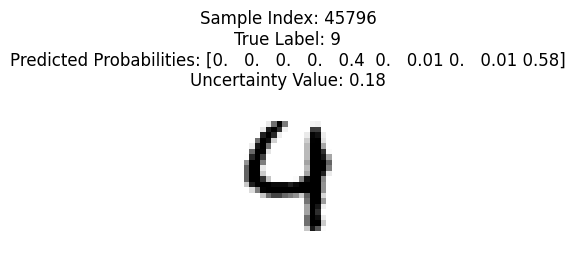

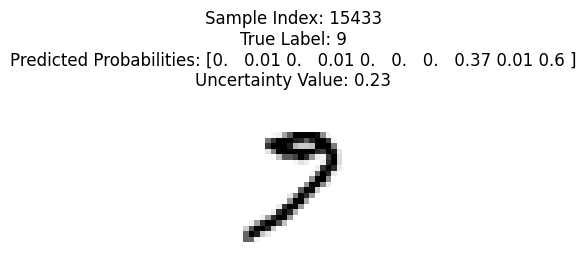

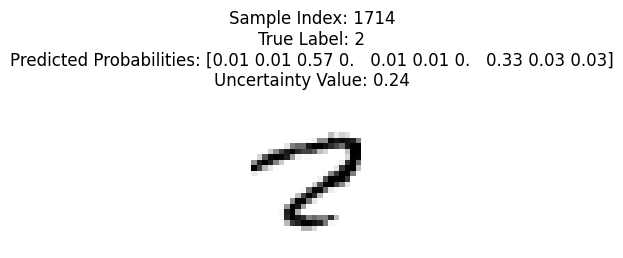

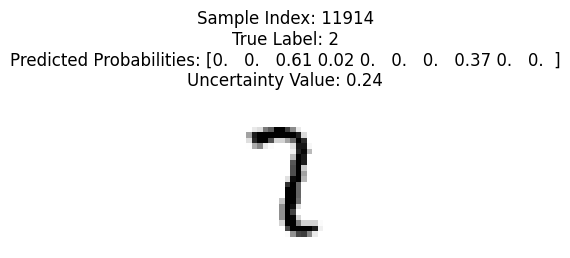

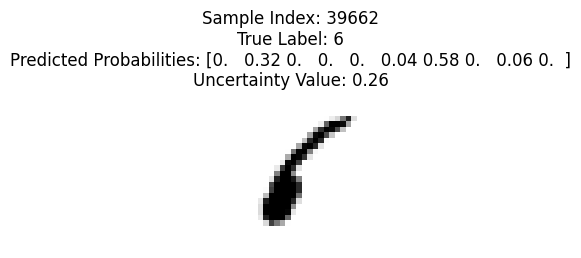

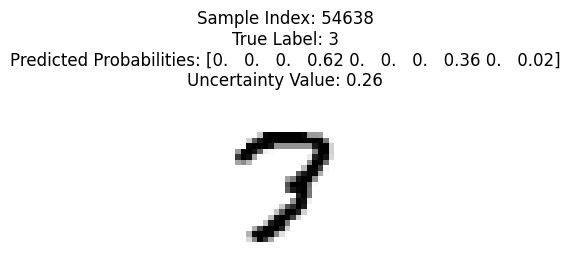

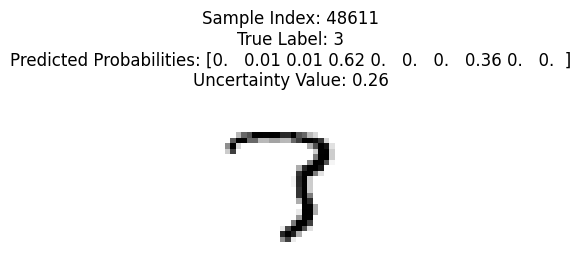

In [22]:
most_uncertain_indices = np.argsort(uncertainty)[:10]

for idx in most_uncertain_indices:
    plt.figure(figsize=(2, 2))
    plt.imshow(X_train.iloc[idx].values.reshape(28, 28), cmap='gray_r')
    plt.title(f"Sample Index: {idx}\nTrue Label: {y_train.iloc[idx]}\nPredicted Probabilities: {proba_train[idx]}\nUncertainty Value: {uncertainty[idx]:.2f}")
    plt.axis('off')
    plt.show()

A comprehensive explaination of entropy is beyond the scope of this project, but for our purposes just know that is a fundamental concept in information theory used to quantify uncertainty or randomness.  Higher entropy means higher uncertainty or randomness.  We will do the same thing we did in the previous calculation, this time using entropy.

In [23]:
entropy = -np.sum(proba_train * np.log(proba_train + 1e-9), axis=1)
most_uncertain_indices_entropy = np.argsort(entropy)[-10:][::-1]

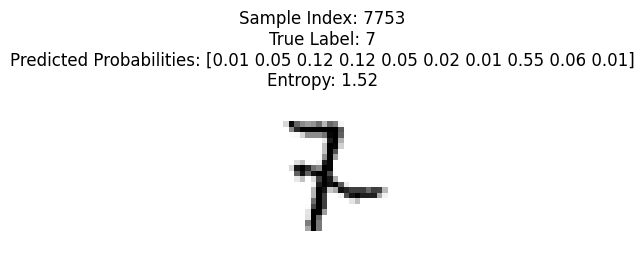

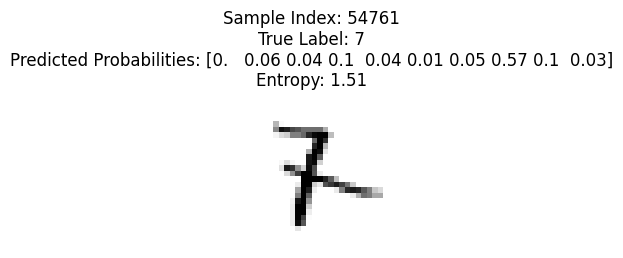

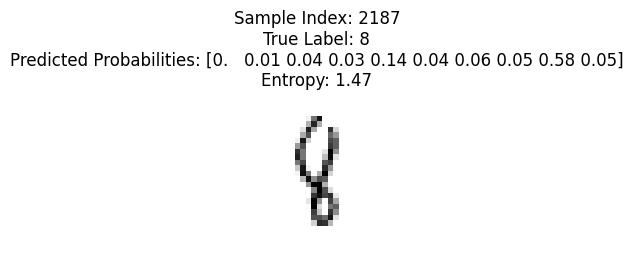

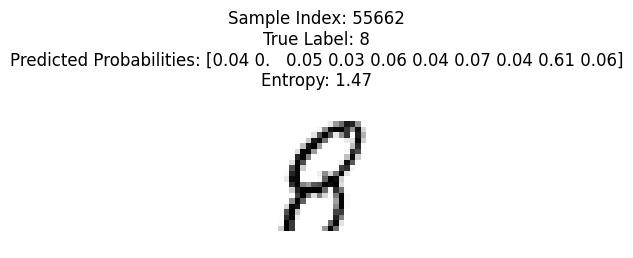

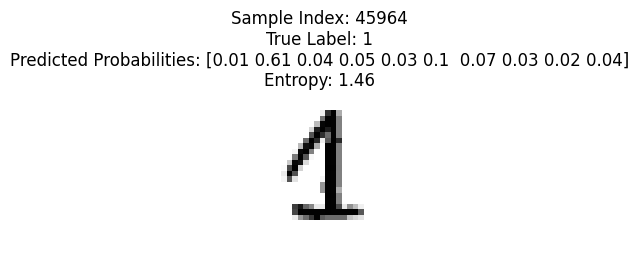

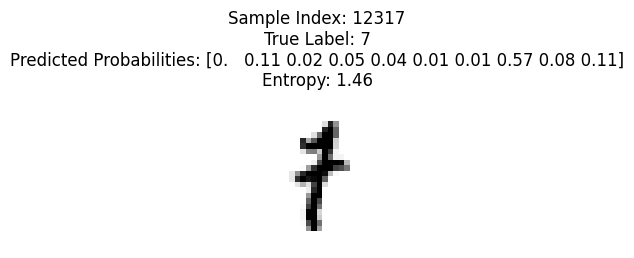

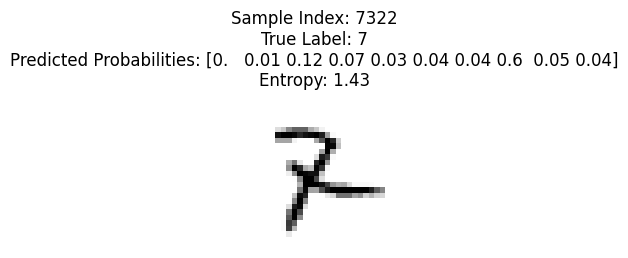

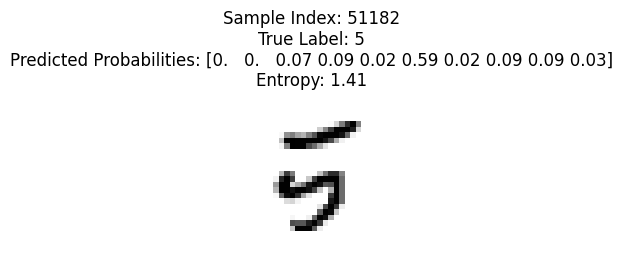

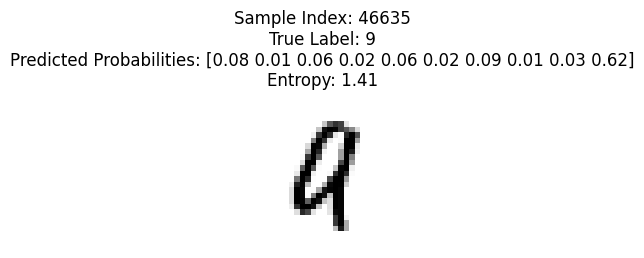

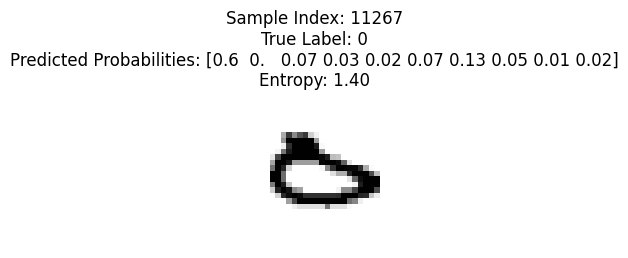

In [24]:
for idx in most_uncertain_indices_entropy:
    plt.figure(figsize=(2, 2))
    plt.imshow(X_train.iloc[idx].values.reshape(28, 28), cmap='gray_r')
    plt.title(f"Sample Index: {idx}\nTrue Label: {y_train.iloc[idx]}\nPredicted Probabilities: {proba_train[idx]}\nEntropy: {entropy[idx]:.2f}")
    plt.axis('off')
    plt.show()

Notice how the two methods identified different 'problematic' samples. The first method primarily found 9's, 4's, and 2's, while the entropy method highlighted a significant number of 7's. The predicted probabilities reveal that the first method tends to find samples where the model is uncertain between two specific classes. In contrast, the entropy method identifies samples where the model is uncertain across several classes, leading to broader misclassification. Upon visual inspection, it doesn't appear that the methods found a common sample, lets varify this.

In [25]:
sorted_indices_uncertainty = sorted(most_uncertain_indices)
sorted_indices_entropy = sorted(most_uncertain_indices_entropy)

# Print the sorted indices side by side
print(f"{'Index from Difference Method':<30}{'Index from Entropy Method'}")
print("=" * 60)

for idx1, idx2 in zip(sorted_indices_uncertainty, sorted_indices_entropy):
    print(f"{idx1:<30}{idx2:<30}")

Index from Difference Method  Index from Entropy Method
1714                          2187                          
11914                         7322                          
15433                         7753                          
15610                         11267                         
37546                         12317                         
37651                         45964                         
39662                         46635                         
45796                         51182                         
48611                         54761                         
54638                         55662                         


In [26]:
common_elements = np.intersect1d(most_uncertain_indices, most_uncertain_indices_entropy)
if (common_elements.size > 0):
    print("Common elements between the two arrays:")
    print(common_elements)
else:
    print("No common elements")

No common elements


In conclusion, the analysis confirmed that the problematic samples identified by each method were unique. Depending on the specific requirements of the project, the next steps could involve refining the dataset by removing the most ambiguous samples, requesting new samples from the original digit writers, or modifying the existing ones to better align with their intended labels. These actions could help improve the model's accuracy and reduce uncertainty in its predictions.